In [1]:
from tools import *
from data import *
from ensemble import *

c:\SUTD\KTH\DD2421 Machine Learning\DD2421-programming-challenge\data.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[bool_cols] = X_train[bool_cols].astype(int)
c:\SUTD\KTH\DD2421 Machine Learning\DD2421-programming-challenge\data.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = le.fit_transform(X_train[col])


In [2]:
results, best_result = train_ensemble(X_train, y_train)

c:\SUTD\KTH\DD2421 Machine Learning\DD2421-programming-challenge\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4399 - loss: 1.0560 - val_accuracy: 0.5930 - val_loss: 0.8467
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5819 - loss: 0.8832 - val_accuracy: 0.6420 - val_loss: 0.7920
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6170 - loss: 0.8274 - val_accuracy: 0.6700 - val_loss: 0.7615
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6224 - loss: 0.8245 - val_accuracy: 0.6750 - val_loss: 0.7437
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6432 - loss: 0.7849 - val_accuracy: 0.6770 - val_loss: 0.7341
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6633 - loss: 0.7611 - val_accuracy: 0.6810 - val_loss: 0.7280
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6603 - loss: 0.7446 - val_accuracy: 0.6820 - val_loss: 0.7236
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6554 - loss: 0.7623 - val_accuracy: 0.

c:\SUTD\KTH\DD2421 Machine Learning\DD2421-programming-challenge\venv\Lib\site-packages\sklearn\metrics\_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
c:\SUTD\KTH\DD2421 Machine Learning\DD2421-programming-challenge\venv\Lib\site-packages\sklearn\metrics\_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
c:\SUTD\KTH\DD2421 Machine Learning\DD2421-programming-challenge\venv\Lib\site-packages\sklearn\metrics\_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
c:\SUTD\KTH\DD2421 Machine Learning\DD2421-programming-challenge\venv\Lib\site-packages\sklearn\metrics\_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
c:\SUTD\KTH\DD2421 Machine Learning\DD2421-programming-challenge\venv\Lib\site-packa

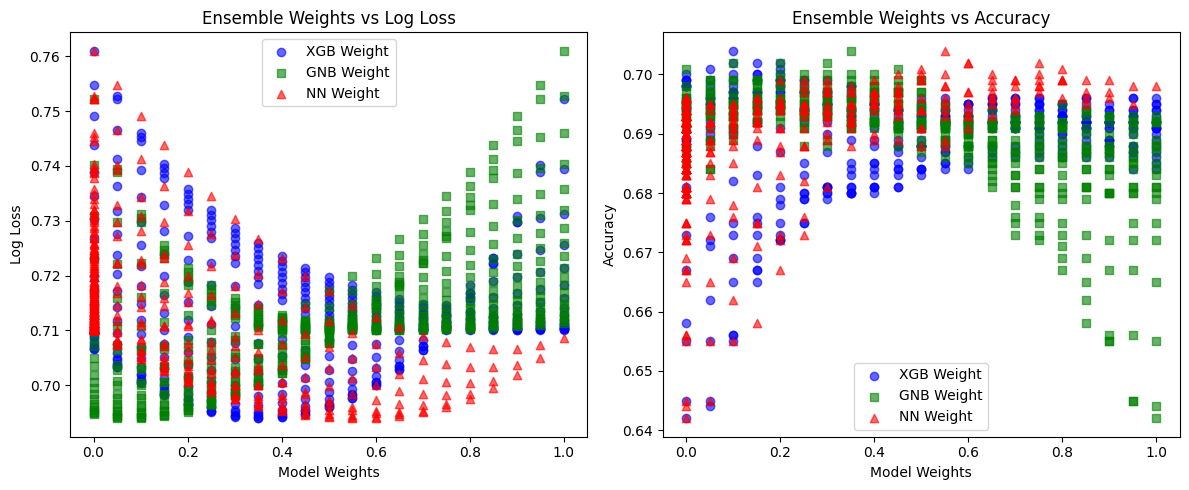

In [5]:
# Extract weights and performance metrics
weights_xgb = [res['weights'][0] for res in results]
weights_gnb = [res['weights'][1] for res in results]
weights_nn = [res['weights'][2] for res in results]
log_losses = [res['log_loss'] for res in results]
accuracies = [res['accuracy'] for res in results]

# Plot Log Loss vs. Model Weights
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(weights_xgb, log_losses, label='XGB Weight', alpha=0.6, marker='o', color='blue')
plt.scatter(weights_gnb, log_losses, label='GNB Weight', alpha=0.6, marker='s', color='green')
plt.scatter(weights_nn, log_losses, label='NN Weight', alpha=0.6, marker='^', color='red')
plt.xlabel("Model Weights")
plt.ylabel("Log Loss")
plt.legend()
plt.title("Ensemble Weights vs Log Loss")

# Plot Accuracy vs. Model Weights
plt.subplot(1, 2, 2)
plt.scatter(weights_xgb, accuracies, label='XGB Weight', alpha=0.6, marker='o', color='blue')
plt.scatter(weights_gnb, accuracies, label='GNB Weight', alpha=0.6, marker='s', color='green')
plt.scatter(weights_nn, accuracies, label='NN Weight', alpha=0.6, marker='^', color='red')
plt.xlabel("Model Weights")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Ensemble Weights vs Accuracy")

plt.tight_layout()
plt.show()


In [6]:
best_result

{'weights': (np.float64(0.35000000000000003),
  np.float64(0.1),
  np.float64(0.5499999999999999)),
 'accuracy': 0.693,
 'log_loss': 0.6939668286828289}

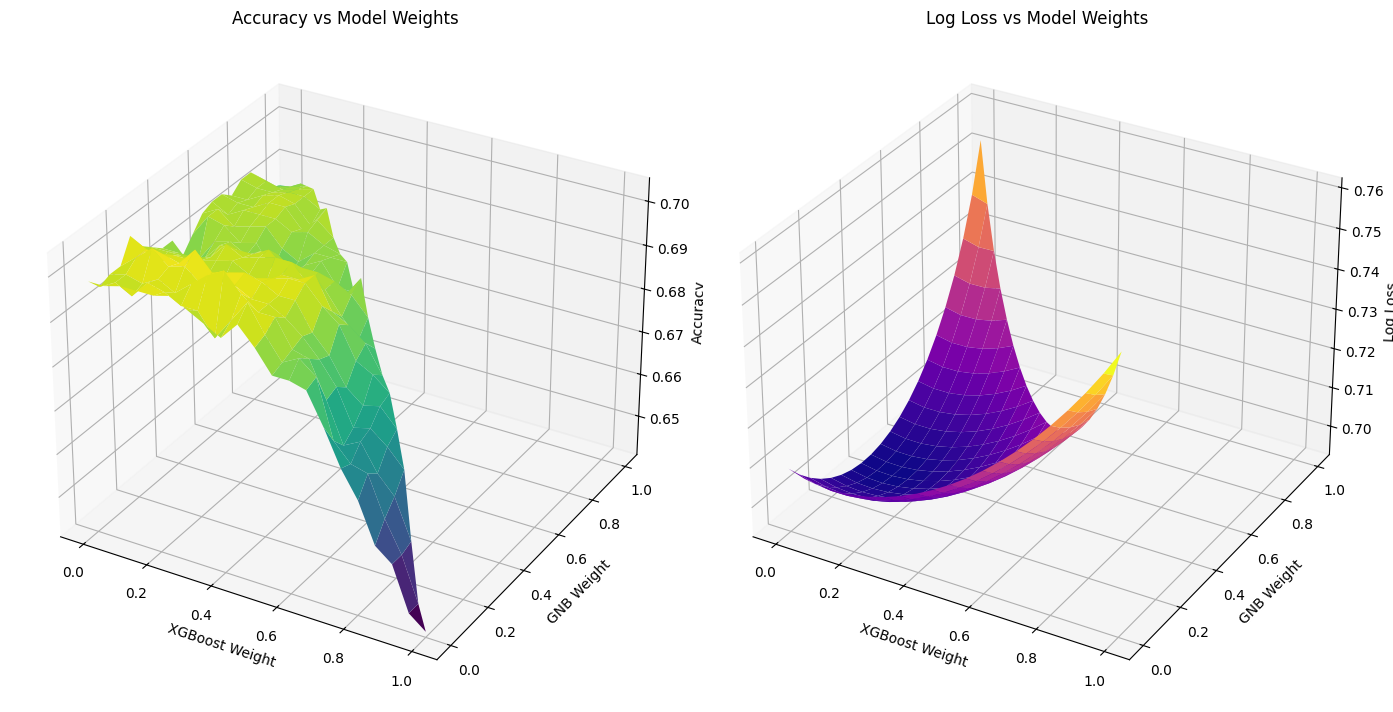

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Extract weights and performance metrics
weights_xgb = [res['weights'][0] for res in results]
weights_gnb = [res['weights'][1] for res in results]
log_losses = [res['log_loss'] for res in results]
accuracies = [res['accuracy'] for res in results]

# Create grid for plotting
weight_options = np.linspace(0, 1, 21)
X, Y = np.meshgrid(weight_options, weight_options)
Z_accuracy = np.full(X.shape, np.nan)
Z_log_loss = np.full(X.shape, np.nan)

# Fill the grid with accuracy and log loss values
for i, w_xgb in enumerate(weight_options):
    for j, w_gnb in enumerate(weight_options):
        if w_xgb + w_gnb <= 1:
            w_nn = 1 - (w_xgb + w_gnb)
            idx = next(k for k, res in enumerate(results) if np.isclose(res['weights'][0], w_xgb) and np.isclose(res['weights'][1], w_gnb))
            Z_accuracy[i, j] = accuracies[idx]
            Z_log_loss[i, j] = log_losses[idx]

# Plotting accuracy
fig = plt.figure(figsize=(14, 7))

# Plot Accuracy surface
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X, Y, Z_accuracy, cmap='viridis')
ax1.set_xlabel('XGBoost Weight')
ax1.set_ylabel('GNB Weight')
ax1.set_zlabel('Accuracy')
ax1.set_title('Accuracy vs Model Weights')

# Plot Log Loss surface
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Y, Z_log_loss, cmap='plasma')
ax2.set_xlabel('XGBoost Weight')
ax2.set_ylabel('GNB Weight')
ax2.set_zlabel('Log Loss')
ax2.set_title('Log Loss vs Model Weights')

plt.tight_layout()
plt.show()
